In [ ]:
!git clone https://github.com/viksit-siddhant/speechClass

In [1]:
import os, threading
import numpy as np
import random
import torchaudio
import torch
import matplotlib.pyplot as plt
from speechClass.models.convModel import ConvModel
from speechClass.utils import analyse_file
from speechClass.datasets.czechSLI import czechData
from speechClass.datasets.LeNormand import LeNormandData
from speechClass.datasets.englishChild import EnglishData
%matplotlib inline

sr = 16000
n_mfcc = 32
maxlen = 32


KeyboardInterrupt: 

In [3]:
audio = torchaudio.load('data/LeNormand/TD/kevin.wav')[0]
spec = torchaudio.transforms.Spectrogram(512)(audio)
print(spec.shape)

torch.Size([1, 257, 102259])


In [2]:
print("Loading czech")
czech = czechData(sr,n_mfcc,maxlen)
print("Loading english")
english = EnglishData(sr,n_mfcc,maxlen)
print("Loading french")
lenormand = LeNormandData(sr,n_mfcc,maxlen,classes=[0])

Loading czech


/home/sid/Projects/speechClass/lib/python3.8/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Loading english
Loading french


In [3]:
from torch.nn.modules import activation
from torchvision import transforms

dataset = torch.utils.data.ConcatDataset([czech,english,lenormand])
train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

convmod = ConvModel([1,n_mfcc,maxlen])

opt = torch.optim.Adam(convmod.parameters(), lr=0.001)

transformer = transforms.Compose([
    transforms.RandomAffine(degrees=0,translate=(0.66,0.66)),
    transforms.GaussianBlur(3, sigma=(0.1, 0.6)),
    ])

loss = torch.nn.NLLLoss(weight=torch.tensor([czech.num_pos,len(czech)-czech.num_pos+len(english)+len(lenormand)]).to("cuda",dtype=torch.float))

def train(model, train_loader, test_loader, loss, opt, epochs,transformer = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Loading model to ", device)
    model.to(device)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        model.train()
        train_loss = 0
        train_steps = len(train_loader)
        counter = 0
        for x, y in train_loader:
            x = x.to(device,dtype=torch.float)
            y = y.to(device,dtype=torch.long)
            y = torch.flatten(y)
            x = transformer(x)
            opt.zero_grad()
            pred = model(x)
            l = loss(pred, y)
            l.backward()
            opt.step()
            train_loss += l.item()
            print(f"Step {counter+1} of {train_steps}", end='\r')
            counter+=1
        print("")
        print("Train Loss: ",train_loss)
        model.eval()
        if test_loader is None:
            continue
        test_loss = 0
        counter = 0
        num_correct_predictions = 0
        test_steps = len(test_loader)
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device,dtype=torch.float)
                y = y.to(device,dtype=torch.long)
                y = torch.flatten(y)
                pred = model(x)
                l = loss(pred, y)
                y = torch.flatten(y)
                test_loss += l.item()

                pred = torch.argmax(pred, dim=1)
                num_correct_predictions += torch.sum(pred == y).item()
                print(f"Step {counter+1} of {test_steps}", end='\r')
                counter+=1
        print("")
        print(f"Test Loss: {test_loss}, Accuracy: {num_correct_predictions/len(test_data)}")

In [4]:
#print(torch.cuda.is_available())
convmod.unfreeze()
train(convmod, train_loader, test_loader, loss, opt, 10, transformer)

Loading model to  cuda
Epoch 1 of 10
Step 674 of 674
Train Loss:  372.32163432240486
Step 169 of 169
Test Loss: 70.8166255056858, Accuracy: 0.3645813996658623
Epoch 2 of 10
Step 674 of 674
Train Loss:  310.2694090716541
Step 169 of 169
Test Loss: 39.39079161733389, Accuracy: 0.7677742713940969
Epoch 3 of 10
Step 674 of 674
Train Loss:  268.91358529031277
Step 169 of 169
Test Loss: 36.42414892464876, Accuracy: 0.8418414702060516
Epoch 4 of 10
Step 674 of 674
Train Loss:  256.44059554487467
Step 169 of 169
Test Loss: 37.32203330099583, Accuracy: 0.8459253759049564
Epoch 5 of 10
Step 674 of 674
Train Loss:  248.60095385834575
Step 169 of 169
Test Loss: 31.452853774651885, Accuracy: 0.913866716168554
Epoch 6 of 10
Step 674 of 674
Train Loss:  225.81338965706527
Step 169 of 169
Test Loss: 56.694443836808205, Accuracy: 0.9255615370335994
Epoch 7 of 10
Step 674 of 674
Train Loss:  225.16585296345875
Step 169 of 169
Test Loss: 36.06398743018508, Accuracy: 0.9118247633191016
Epoch 8 of 10
Step 

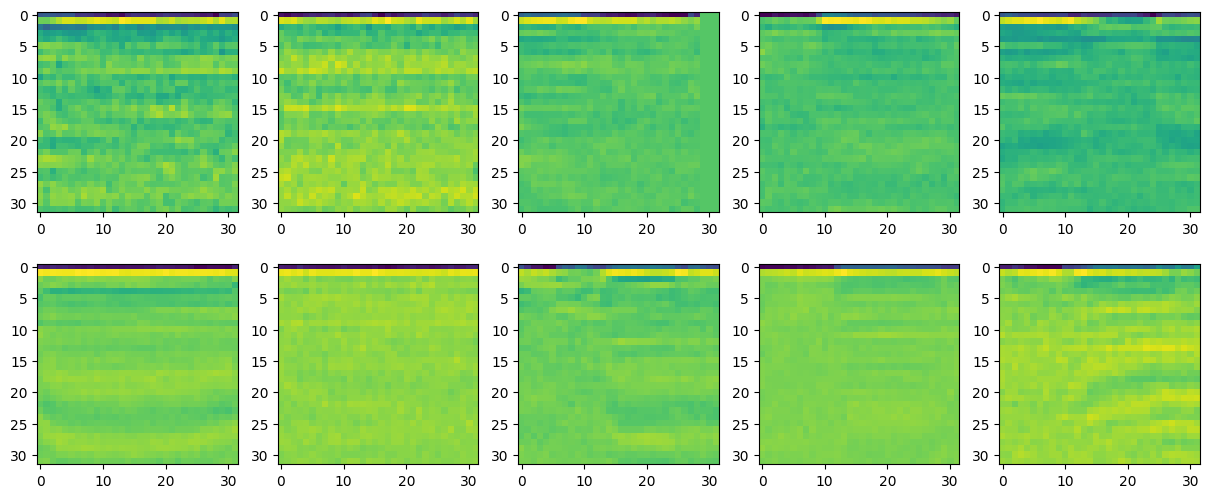

In [6]:
import matplotlib.pyplot as plt

#Plot 10 random images from model.train_x

figs, axs = plt.subplots(2,5, figsize=(15,6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(train_data[random.randint(0,len(train_data))][0][0], cmap='viridis')

plt.show()

/home/sid/Projects/speechClass/lib/python3.8/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


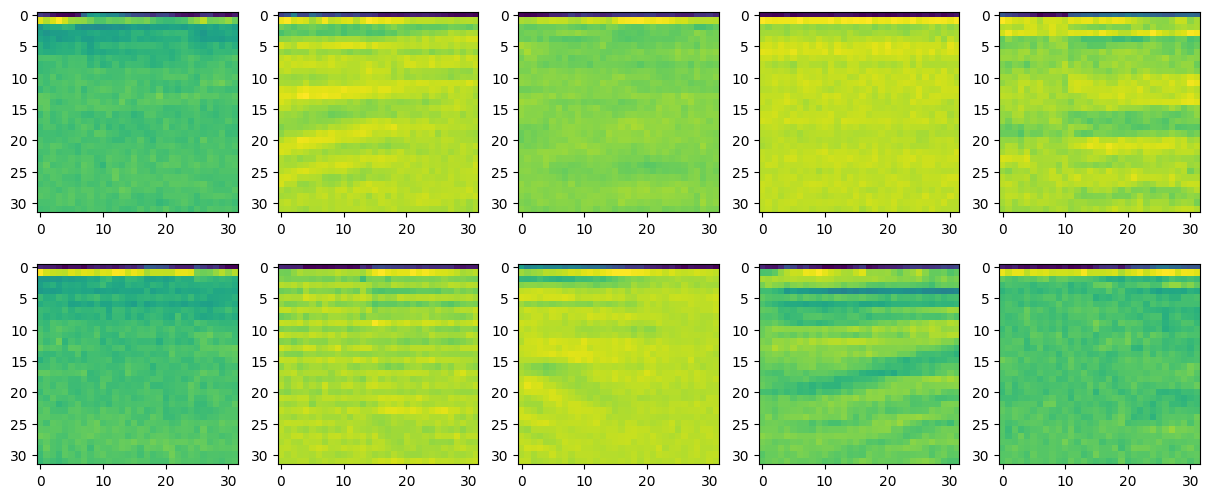

In [2]:
lenormand = LeNormandData(16000, 32,32)
#print(model.train_x[0])

#Plot 10 random images from model.train_x

figs, axs = plt.subplots(2,5, figsize=(15,6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(lenormand[np.random.randint(0,len(lenormand))][0].squeeze())

plt.show()

In [18]:
train_fraction = 0.1
train_ln,test_ln = torch.utils.data.random_split(lenormand,[int(train_fraction*len(lenormand)),len(lenormand)-int(train_fraction*len(lenormand))])
train_ln = torch.utils.data.DataLoader(train_ln, batch_size=32, shuffle=True)
test_ln = torch.utils.data.DataLoader(test_ln, batch_size=32, shuffle=True)
convmod.freeze(1)

train(convmod, train_ln, test_ln, loss, opt, 20, transformer)

Loading model to  cuda
Epoch 1 of 20
Step 45 of 45
Train Loss:  43.47036835551262
Step 398 of 398
Test Loss: 444.3836033940315, Accuracy: 1.3233710785223687
Epoch 2 of 20
Step 45 of 45
Train Loss:  19.118106991052628
Step 398 of 398
Test Loss: 195.95030017197132, Accuracy: 1.1275292370521626
Epoch 3 of 20
Step 45 of 45
Train Loss:  17.72462373971939
Step 398 of 398
Test Loss: 153.25282181799412, Accuracy: 1.1566734731761648
Epoch 4 of 20
Step 45 of 45
Train Loss:  15.85427931509912
Step 398 of 398
Test Loss: 138.34025119245052, Accuracy: 1.2105067755708185
Epoch 5 of 20
Step 45 of 45
Train Loss:  16.32554306089878
Step 398 of 398
Test Loss: 144.26232835650444, Accuracy: 1.189344718767403
Epoch 6 of 20
Step 45 of 45
Train Loss:  17.16118237376213
Step 398 of 398
Test Loss: 128.51167680323124, Accuracy: 1.222758492667533
Epoch 7 of 20
Step 45 of 45
Train Loss:  15.594027891755104
Step 398 of 398
Test Loss: 128.00936096906662, Accuracy: 1.2233153888992019
Epoch 8 of 20
Step 45 of 45
Train

In [19]:
ln_loader = torch.utils.data.DataLoader(lenormand, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_correct_0 = 0
num_correct_1 = 0
num_0 = 0
num_1 = 0
for x,y in ln_loader:
    x = x.to(device,dtype=torch.float)
    y = y.numpy().flatten()
    with torch.no_grad():
        pred = np.argmax(convmod(x).cpu().numpy(),axis=1)
        num_correct_0 += np.sum((pred < 0.5) & (y == 0))
        num_correct_1 += np.sum((pred >= 0.5) & (y == 1))
        print(pred)
        print(y)
        num_0 += np.sum(y == 0)
        num_1 += np.sum(y == 1)

print(f"Accuracy on zero: {num_correct_0/num_0}")
print(f"Accuracy on one: {num_correct_1/num_1}")


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1.]
[1 1 1 1 1